### **ASSIGNMENT #2 - DATA SCIENCE AND DECISION MAKING.**
**STAGE 2: MODELLING AND TESTING**

*NOTEBOOK MADE BY: JUAN DAVID VELASQUEZ RESTREPO - 2400901*

### Libraries and Data Import

This first section imports all the necessary set of codes for the proper code functioning, such as the libraries required for importing the Machine Learning models described in the plans of stage 1. These include SVM, Logistic Regression, KNN, Random Forest and XGBoost. Also, after the latter is included, the packages regarding the performance metrics like MCC, F1 score and the ROC - AUC curve are included in this code, as well as the precision/recall calculator, the Cross Validation method, numpy and pandas.

In [452]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score



### Declaration of Functions

The following section comprehends the code of the functions that will be needed throughout the notebook.
The code for ROC - AUC was taken from: https://www.geeksforgeeks.org/multiclass-receiver-operating-characteristic-roc-in-scikit-learn/

In [ ]:
# The following function is used to declare a scorer for the GridSearchCV method implemented in the training of the models. This Scorer will consider to
# extract the F1 score for each class and then computes an average between the performance of the two classes to predict.

def f1_type0(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')


# The next function has the task of train the model using the GridSearchCV method and applying the scorer previously defined.
# Its input parameters include the model to train, the training and test sets and the scorer that is defined in the function "f1_type0".

def model_training(model, param_grid, x_train, y_train, x_test, y_test, scorer = make_scorer(f1_type0)):
    
    # the GridSearchCV with cross-validation is set up with 3 folds for a faster training process.
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = scorer)

    grid_search.fit(x_train, y_train) # Here the model is fitted on the training data.

    print(classification_report(y_test, (grid_search.best_estimator_).predict(x_test))) # Prints a detailed classification report including precision, recall and F1 Score.

    f1 = f1_score(y_test, (grid_search.best_estimator_).predict(x_test), average='macro') # Computes the F1 score of the model itself.

    print("F1 Score:", f1) # Prints the F1 score.

    return grid_search.best_estimator_ # Returns the best model according to the F1 score.

# The following function performs the selection of the best model from a given class. Here, the model receives the 5 models previously trained, the test set and the
# parameter that indicates whether the plot is necessary or not (this is for test purposes).

def model_selector(model1, model2, model3, model4, model5, X_test, y_test, plot = True):
    models = [model1, model2, model3, model4, model5] # Models are stored in a list.
    score = 0 # Store the F1 scores of each model.
    best_model = None # Saves the parameters of the best model.
    best_score = 0 # Store the F1 score of the best model.

    for model in models: # Iterates over the models.
        score = f1_score(y_test, model.predict(X_test), pos_label=0) # Computes the F1 score only for the class 0 which is the class of interest.
        if score > best_score: # If the current F1 score is greater than the best F1 score, it is stored.
            best_score = score # Stores the F1 score of the best model. 
            best_model = model # Stores the parameters of the best model.


    if plot == True: # If the plot is necessary.
        # Saves the probabilities of the class to determine.
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # Calculates the ROC - AUC Curve.
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plots ROC.
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        print(classification_report(y_test, best_model.predict(X_test))) # Prints a detailed classification report including precision, recall and F1 Score.

        print("The Mathhews Correlation Coefficient is:", MCC(y_test, best_model.predict(X_test))) # Prints the Matthews Correlation Coefficient.

        y_pred = best_model.predict(X_test) # Stores the predictions of the best model.

        precision = precision_score(y_test, y_pred, average=None) # Stores the precision of the best model.
        recall = recall_score(y_test, y_pred, average=None) # Stores the recall of the best model.

        # Class labels
        classes = ['Class 0', 'Class 1']

        # Create bar chart
        plt.bar(classes, precision, width=0.4, label='Precision', align='center') # Plots the precision of the best model.
        plt.bar(classes, recall, width=0.4, label='Recall', align='edge') # Plots the recall of the best model.

        # Add plot details
        plt.ylabel('Score')
        plt.title('Precision and Recall per Class')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        cm = confusion_matrix(y_test, y_pred) # Creates the confusion matrix.
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']) # Plots the confusion matrix.
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix') 
        plt.grid(False)
        plt.show()

    return best_model

The following line will ensure that the dataset explored and preprocessed from the previous stage is imported into the notebook in question.

In [408]:
X_train = pd.read_csv('x_train.csv') # Training set imported.
y_train = pd.read_csv('y_train.csv') # Training labels imported.
X_test = np.array(pd.read_csv('x_test.csv')) # Test set imported.
y_test = pd.read_csv('y_test.csv') # Test labels imported.

Considering that the strategy to implement follows the Ensemble architecture, it is important to split the dataset in another two parts. One will contain the data that will be used to train the Base models (SVM, Random Forest, KNN, XGBoost and Logistic Regressioh) and the other one will hold the training set for the general model or the model that will receive the individual predictions of the base models. Hence, the set is splitted in 50/50.

In [ ]:
X_train, X_train_gen, y_train, y_train_gen = train_test_split(X_train, y_train, random_state=42, train_size = 0.75, shuffle = True) # Dataset split into base model training sets 
# and general model training sets at 75/25.

Once the data is properly imported, the next step is to convert each in just a binary label depending on the class to predict, e.g for the class 0, the idea is to convert those rows whose label is different from 0 and convert them into the number 1, indicating that the sample does not belong to the class to predict. This hence, is similar to the strategy OvA (One vs All). This method is applied given that there are not sufficient samples for a single model to classify between 4 different classes, therefore, a better approach is to build independent models for each class and then, build a general model that is capable to receive the results of each model and predict the class of the input feature.

The following shows what represents each class of the data: 


  - Class 0: If not ADHD and Male.

  - Class 1: If not ADHD and Female.

  - Class 2: ADHD and Male.
  
  - Class 3: ADHD and Female.

### Model #1. Class 0 - Not ADHD and Male.

The lines below convert to 1 all those labels whose values are different from 0, indicating that those who have 0, are males and have ADHD and those who have 1 are either males without ADHD or Females.

In [410]:
class0_ytrain = y_train.applymap(lambda x: 1 if x != 0 else x) # The values are converted. 0 Will remain as they are and all those above 0 will be 1.
class0_ytest = y_test.applymap(lambda x: 1 if x != 0 else x) # The same applies to the test set.

Considering that there is no sufficient data for the classes 0,1 and 3 (please observe code of the Stage 1), the idea is to achieve an approximation to class balancing by creating artificial data or data that is not explicitly contained in the original data. With this, the performance of the models could gain an improvement and these might find and describe the patterns found in patients according to the presence of ADHD and their sex. The strategy followed for data augmentation is SMOTE-NC, this allows the developer to generate artificial data for both categorical and numerical data.

In [411]:
# Before using SMOTENC, it is necessary to create an array that holds the names of the columns that are categorical in the dataset.
categorical_indices = np.arange(897, 908).tolist()  # List of the categotical columns.

# SmoteNC is initialized by choosing that the non dominant class will be oversampled to 85% of the quantity of the samples of the dominant class.
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42, sampling_strategy=0.85)

# SMOTENC is applied to the training set.
class0_Xtrain, class0_ytrain = smote_nc.fit_resample(X_train, class0_ytrain)

#### Support Vector Machine

The following code describes the training of the SVM for the class 0.

In [412]:
param_grid = {
    'C': np.logspace(0.001, 100, 10),  # Regularization strength
    'kernel': ['linear', 'rbf'],   # Commonly used kernels
    'gamma': ['scale', 'auto']     # Kernel coefficient for 'rbf'
}
svc_class0 = model_training(SVC(random_state=42, probability=True), param_grid, class0_Xtrain, class0_ytrain, X_test, class0_ytest)

              precision    recall  f1-score   support

           0       0.28      0.55      0.37        38
           1       0.90      0.74      0.81       205

    accuracy                           0.71       243
   macro avg       0.59      0.64      0.59       243
weighted avg       0.80      0.71      0.74       243

F1 Score: 0.5906664452300173


#### Logistic Regression

The following code describes the training of the Logistic Regression for the class 0.

In [413]:
param_grid = {
    'C': np.logspace(0.001, 10, 5), # Regularization Strength
    'penalty': ['l2'], # L2 Regularization, commonly used.
    'solver': ['lbfgs', 'liblinear', 'saga'] # Solver eficient for Logistic Regression.
}

lr_class0 = model_training(LogisticRegression(random_state=42), param_grid, class0_Xtrain, class0_ytrain, X_test, class0_ytest)

              precision    recall  f1-score   support

           0       0.60      0.16      0.25        38
           1       0.86      0.98      0.92       205

    accuracy                           0.85       243
   macro avg       0.73      0.57      0.58       243
weighted avg       0.82      0.85      0.81       243

F1 Score: 0.5839041095890412


#### KNN

The following code describes the training of the KNN for the class 0.

In [414]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]                        # Power parameter: 1 = Manhattan, 2 = Euclidean
}

knn_class0 = model_training(KNeighborsClassifier(), param_grid, class0_Xtrain, class0_ytrain, X_test, class0_ytest)

              precision    recall  f1-score   support

           0       0.16      1.00      0.27        38
           1       0.00      0.00      0.00       205

    accuracy                           0.16       243
   macro avg       0.08      0.50      0.14       243
weighted avg       0.02      0.16      0.04       243

F1 Score: 0.13523131672597866


#### Random Forest

The following code describes the training of the Random Forest for the class 0.

In [415]:
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees in the forest
    'max_depth': [None, 5, 10],          # Maximum depth of each tree
    'max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy']    # Function to measure the quality of a split
}

rf_class0 = model_training(RandomForestClassifier(class_weight='balanced'), param_grid, class0_Xtrain, class0_ytrain, X_test, class0_ytest)

              precision    recall  f1-score   support

           0       0.16      1.00      0.27        38
           1       1.00      0.01      0.02       205

    accuracy                           0.16       243
   macro avg       0.58      0.50      0.15       243
weighted avg       0.87      0.16      0.06       243

F1 Score: 0.1458625525946704


#### XGBoost

The following code describes the training of the XGBoost for the class 0.

In [416]:
param_grid = {
    'n_estimators': [1500, 2000], # Number of trees in the forest
    'max_depth': [3, 6], # Maximum depth of each tree, above 6 the model will overfit.
    'subsample': [0.5, 1]  # 0.5 is used in order to avoid overfitting.
}

xgb_class0 = model_training(XGBClassifier(random_state=42, device = 'gpu', scale_pos_weight= ((class0_ytrain == 0).sum() / (class0_ytrain == 1).sum()).item()), 
                            param_grid, class0_Xtrain, class0_ytrain, X_test, class0_ytest)

              precision    recall  f1-score   support

           0       0.29      0.45      0.35        38
           1       0.89      0.80      0.84       205

    accuracy                           0.74       243
   macro avg       0.59      0.62      0.60       243
weighted avg       0.79      0.74      0.76       243

F1 Score: 0.5975961538461538


Selection of the Best Model for Class 0

The Function previously created performs the selection of the best model for the class 0. In the next section, a detailed analysis of the performance of the model will be made.

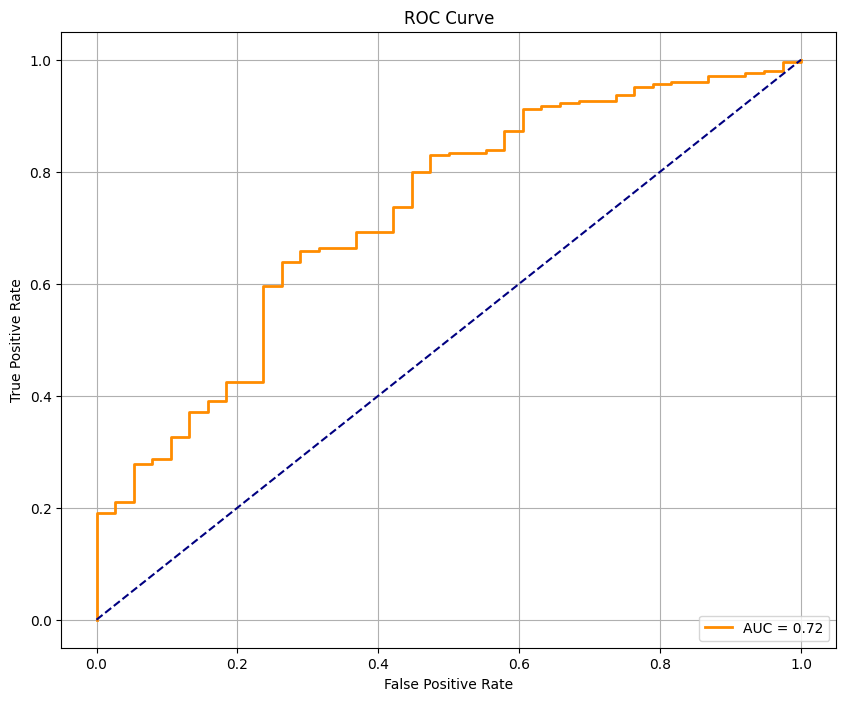

              precision    recall  f1-score   support

           0       0.28      0.55      0.37        38
           1       0.90      0.74      0.81       205

    accuracy                           0.71       243
   macro avg       0.59      0.64      0.59       243
weighted avg       0.80      0.71      0.74       243

The Mathhews Correlation Coefficient is: 0.22740876011604516


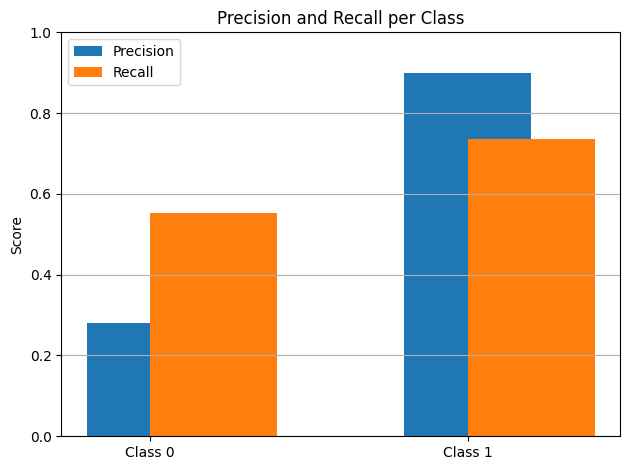

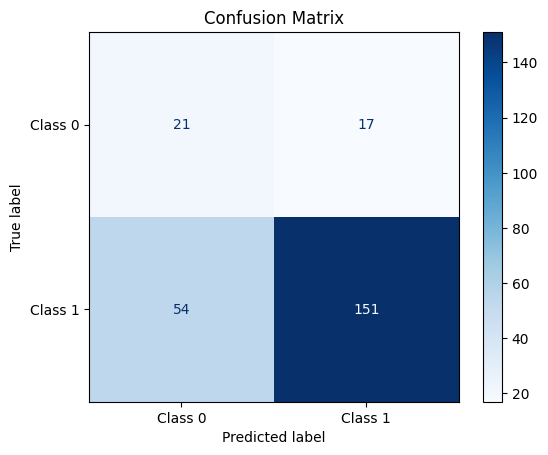

In [453]:
best_class0 = model_selector(svc_class0, lr_class0, knn_class0, rf_class0, xgb_class0, X_test, class0_ytest) # The best model is selected.

Observing the results provided above, we can detail that this model obtained the highest Area Under the curve against the other models trained in this notebook. This inidicates that the model can better differentiate the class 1 against the class 0 better than any other model. However, despite this model is not random guessing or classifying the data given that the line of the curve oscillates above the diagonal, the table of results highlights that when a sample which is expected to be predicted as class 0, this model struggles notably. This, achieved a precision of 0.28, a recall of 0.55 and a F1 Score of 0.37 which is not viable for this application mainly because finds difficulties to identify and perceive the patterns that the class 0 has. 

On the other hand, for class 1, the model is certainly appropiate and performs in an outstanding way, achieving a score of 0.81, precision of 0.90 and recall of 0.74, which is approximately a difference of more than 0.30 in every aspect comparing to the class 0. This then, lead to state that the model is heavily influenced by the class imbalance with much better performance on the majority class and weaker performance on the minority class. This statement can be reinforced also on the results obtained in the confusion matrix, where most of the right classifications are on the class 1 rather than on the class 0, where fails in most of the cases.



### Model #2. Class 1 - Not ADHD and Female.

The line below converts to 1 all those samples that are not 1, and those that were already 1 will be 0. This model will classify if the patient is Female and does not have ADHD giving the number 0. Otherwise, if the patient is Female and has ADHD or is Male, the output is 1.

In [418]:
# Conversion of the labels to 0 and 1.
class1_ytrain = y_train.applymap(lambda x: 1 if x != 1 else 0)
class1_ytest = y_test.applymap(lambda x: 1 if x != 1 else 0)

In [419]:
# SMOTENC is applied to the training set.
class1_Xtrain, class1_ytrain = smote_nc.fit_resample(X_train, class1_ytrain)

#### Support Vector Machine

Training of the SVM for class 1.

In [420]:
param_grid = {
    'C': np.logspace(0.001, 100, 10),  # Regularization strength
    'kernel': ['linear', 'rbf'],   # Commonly used kernels
    'gamma': ['scale', 'auto']     # Kernel coefficient for 'rbf'
}
svc_class1 = model_training(SVC(random_state=42, probability=True), param_grid, class1_Xtrain, class1_ytrain, X_test, class1_ytest)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.89      0.99      0.94       216

    accuracy                           0.88       243
   macro avg       0.44      0.50      0.47       243
weighted avg       0.79      0.88      0.83       243

F1 Score: 0.4682713347921225


#### Logistic Regression

Training of the Logistic Regression for class 1.

In [421]:
param_grid = {
    'C': np.logspace(0.001, 10, 5), # Regularization Strength
    'penalty': ['l2'], # L2 Regularization, commonly used.
    'solver': ['lbfgs', 'liblinear', 'saga'] # Solver eficient for Logistic Regression.
}

lr_class1 = model_training(LogisticRegression(random_state=412), param_grid, class1_Xtrain, class1_ytrain, X_test, class1_ytest)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.89      0.99      0.94       216

    accuracy                           0.88       243
   macro avg       0.44      0.50      0.47       243
weighted avg       0.79      0.88      0.83       243

F1 Score: 0.4682713347921225


#### KNN

Training of the KNN for class 1.

In [422]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]                        # Power parameter: 1 = Manhattan, 2 = Euclidean
}

knn_class1 = model_training(KNeighborsClassifier(), param_grid, class1_Xtrain, class1_ytrain, X_test, class1_ytest)

              precision    recall  f1-score   support

           0       0.11      1.00      0.20        27
           1       0.00      0.00      0.00       216

    accuracy                           0.11       243
   macro avg       0.06      0.50      0.10       243
weighted avg       0.01      0.11      0.02       243

F1 Score: 0.1


#### Random Forest

Training of the Random Forest for class 1.

In [423]:
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees in the forest
    'max_depth': [None, 5, 10],          # Maximum depth of each tree
    'max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy']    # Function to measure the quality of a split
}

rf_class1 = model_training(RandomForestClassifier(class_weight='balanced'), param_grid, class1_Xtrain, class1_ytrain, X_test, class1_ytest)

              precision    recall  f1-score   support

           0       0.12      1.00      0.22        27
           1       1.00      0.10      0.18       216

    accuracy                           0.20       243
   macro avg       0.56      0.55      0.20       243
weighted avg       0.90      0.20      0.19       243

F1 Score: 0.20130794253185147


#### XGBoost

Training of the XGBoost for class 1.

In [424]:
param_grid = {
    'n_estimators': [1500, 2000],
    'max_depth': [3, 6],
    'subsample': [0.5, 1]  # 0.5 is used in order to avoid overfitting.
}

xgb_class1 = model_training(XGBClassifier(random_state=42, device = 'gpu', scale_pos_weight= ((class1_ytrain == 0).sum() / (class1_ytrain == 1).sum()).item()), 
                            param_grid, class1_Xtrain, class1_ytrain, X_test, class1_ytest)

              precision    recall  f1-score   support

           0       0.27      0.11      0.16        27
           1       0.90      0.96      0.93       216

    accuracy                           0.87       243
   macro avg       0.58      0.54      0.54       243
weighted avg       0.83      0.87      0.84       243

F1 Score: 0.543233082706767


Selection of Best Model

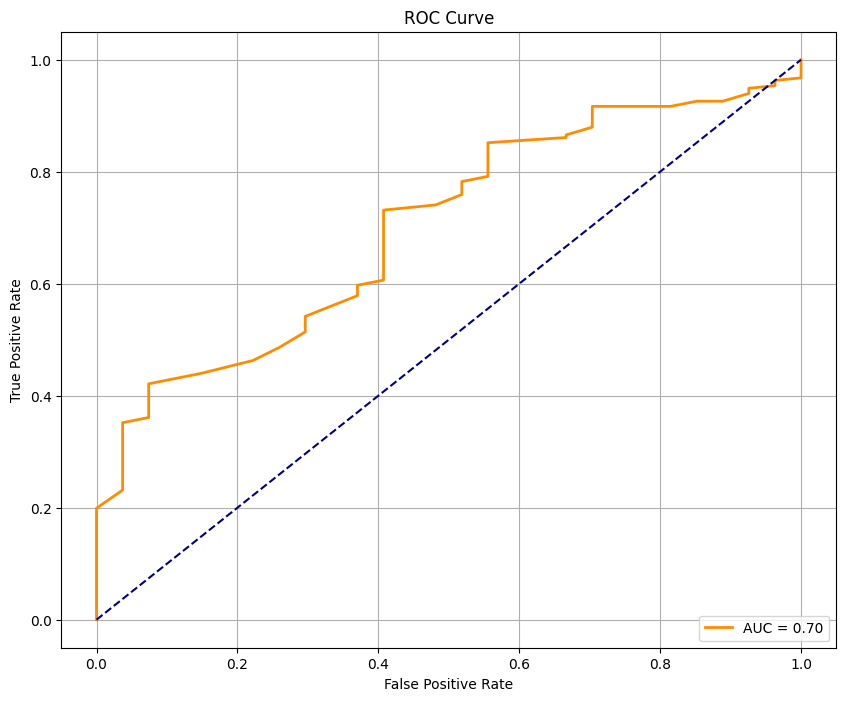

              precision    recall  f1-score   support

           0       0.12      1.00      0.22        27
           1       1.00      0.10      0.18       216

    accuracy                           0.20       243
   macro avg       0.56      0.55      0.20       243
weighted avg       0.90      0.20      0.19       243

The Mathhews Correlation Coefficient is: 0.11155016321829005


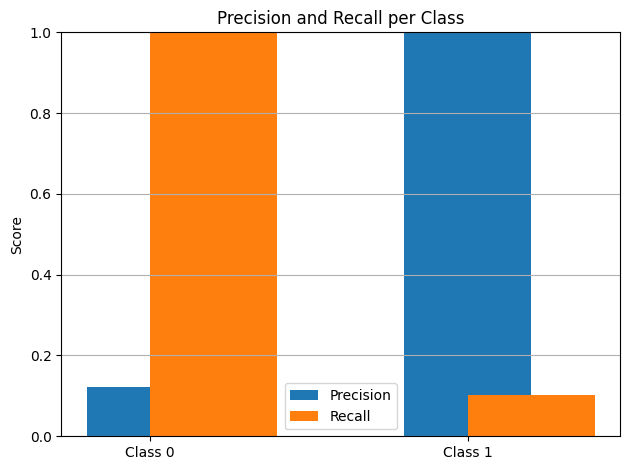

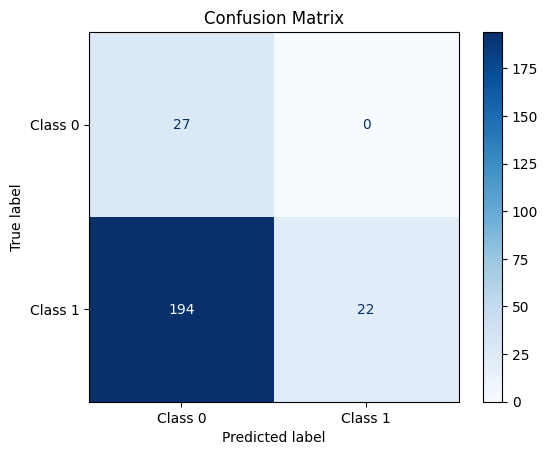

In [454]:
best_class1 = model_selector(svc_class1, lr_class1, knn_class1, rf_class1, xgb_class1, X_test, class1_ytest)

Considering the plot obtained from the ROC - AUC Curve, it is possible to detail that the model performs well and is capable to differentiate the characteristics of each class and since the area under the curve is above 0.5 and the line oscillates above the diagonal of the plot, this means that the model performs better than a random classifier. However, even though can distinguish from class 0n and 1, the model can still improve its performance but given the limitations of the quantity of features with the label "0" and since there is an evident class imbalance, the best model still struggles to find an optimum way to determine if the patient is Female without ADHD.

On the other hand, taking into account the table of the precision, recall, f1 score and support, the model fails when predicts the class 0, given that only 12% of the times predicts it correctly. Regarding recall, the model can identify the real instances of the class 0 but, still has a low performance considering the F1 Score which is 0.22, mainly because it is lowered due to the poor capacity of detecting the class 0.

Also, the MCC is very low, obtaining a value of 11.1%. This indicates that the model is still not viable for differentiate the class 0 and requires more data to perform in an appropiate way.

Observing the confusion matrix, we can detail that the model is mostly biased towards the class 0 rather than class 1. As seen, most of the classifications are established as class 0 when they should be as class 1.

### Model #3. Class 2 - ADHD and Male.

For this case, all those labels that are different from 2 will be converted to 1, otherwise, if it is 2, then will become 0. The models of this class will determine if the patient is male and has ADHD (which is the most dominant class in the dataset) giving the number 0, if not, whether the patient is Female or is Male and does not have ADHD then the outcome is 1.

In [426]:
class2_ytrain = y_train.applymap(lambda x: 1 if x != 2 else 0) # Conversion of the labels to 0 and 1.
class2_ytest = y_test.applymap(lambda x: 1 if x != 2 else 0)

Since this is the most dominant class, data oversampling is not required for this class.

In [ ]:
class2_Xtrain, class2_ytrain = X_train, class2_ytrain # No SMOTENC is applied to the training set.

#### Support Vector Machine

Code of the training of the SVM for class 2.

In [428]:
param_grid = {
    'C': np.logspace(0.001, 100, 25),  # Regularization strength
    'kernel': ['linear', 'rbf'],   # Commonly used kernels
    'gamma': ['scale', 'auto']     # Kernel coefficient for 'rbf'
}
svc_class2 = model_training(SVC(random_state=42, probability=True), param_grid, class2_Xtrain, class2_ytrain, X_test, class2_ytest)

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       133
           1       0.57      0.66      0.62       110

    accuracy                           0.63       243
   macro avg       0.63      0.63      0.63       243
weighted avg       0.63      0.63      0.63       243

F1 Score: 0.6252859539423516


#### Logistic Regression

Code of the training of the LR for class 2.

In [429]:
param_grid = {
    'C': np.logspace(0.001, 10, 5), # Regularization Strength
    'penalty': ['l2'], # L2 Regularization, commonly used.
    'solver': ['lbfgs', 'liblinear', 'saga'] # Solver eficient for Logistic Regression.
}

lr_class2 = model_training(LogisticRegression(random_state=42), param_grid, class2_Xtrain, class2_ytrain, X_test, class2_ytest)

              precision    recall  f1-score   support

           0       0.70      0.59      0.64       133
           1       0.58      0.69      0.63       110

    accuracy                           0.63       243
   macro avg       0.64      0.64      0.63       243
weighted avg       0.64      0.63      0.63       243

F1 Score: 0.6337200440342112


#### KNN

Code of the training of the KNN for class 2.

In [430]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]                        # Power parameter: 1 = Manhattan, 2 = Euclidean
}

knn_class2 = model_training(KNeighborsClassifier(), param_grid, class2_Xtrain, class2_ytrain, X_test, class2_ytest)

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       133
           1       0.52      0.42      0.46       110

    accuracy                           0.56       243
   macro avg       0.55      0.55      0.55       243
weighted avg       0.56      0.56      0.56       243

F1 Score: 0.5482954545454546


#### Random Forest

Code of the training of the Random Forest for class 2.

In [431]:
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees in the forest
    'max_depth': [None, 5, 10],          # Maximum depth of each tree
    'max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy']    # Function to measure the quality of a split
}

rf_class2 = model_training(RandomForestClassifier(class_weight='balanced'), param_grid, class2_Xtrain, class2_ytrain, X_test, class2_ytest)

              precision    recall  f1-score   support

           0       0.67      0.74      0.71       133
           1       0.65      0.56      0.60       110

    accuracy                           0.66       243
   macro avg       0.66      0.65      0.65       243
weighted avg       0.66      0.66      0.66       243

F1 Score: 0.6545423023578363


#### XGBoost

Code of the training of the XGBoost for class 2.

In [432]:
param_grid = {
    'n_estimators': [1500, 2000],
    'max_depth': [3, 6],
    'subsample': [0.5, 1]  # 0.5 is used in order to avoid overfitting.
}

xgb_class2 = model_training(XGBClassifier(random_state=42, device = 'gpu', scale_pos_weight= ((class2_ytrain == 0).sum() / (class2_ytrain == 1).sum()).item()), 
                            param_grid, class2_Xtrain, class2_ytrain, X_test, class2_ytest)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       133
           1       0.61      0.61      0.61       110

    accuracy                           0.65       243
   macro avg       0.64      0.64      0.64       243
weighted avg       0.65      0.65      0.65       243

F1 Score: 0.6428913192071086


Selection of Best Model

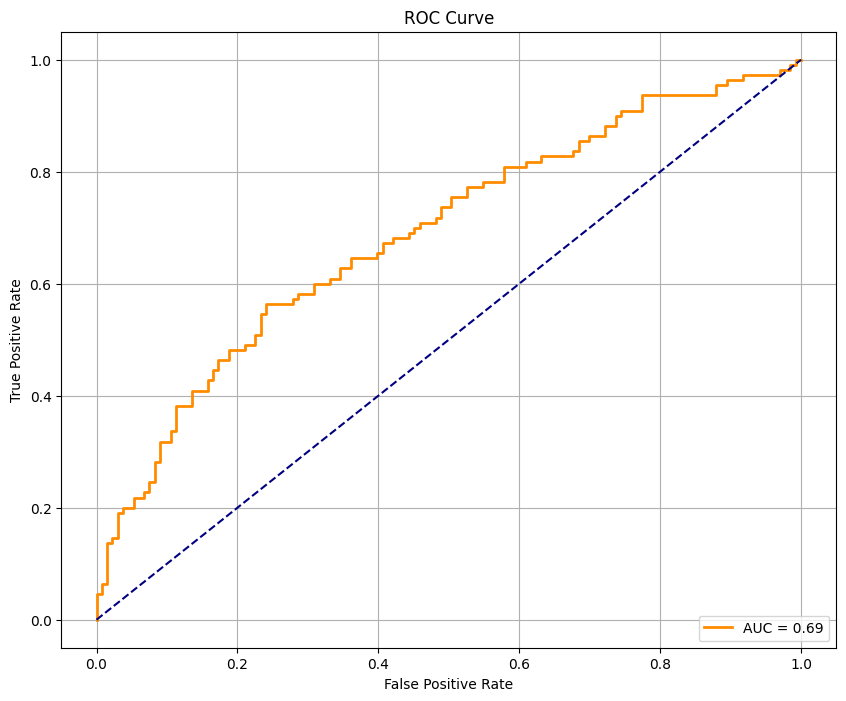

              precision    recall  f1-score   support

           0       0.67      0.74      0.71       133
           1       0.65      0.56      0.60       110

    accuracy                           0.66       243
   macro avg       0.66      0.65      0.65       243
weighted avg       0.66      0.66      0.66       243

The Mathhews Correlation Coefficient is: 0.31359905147674605


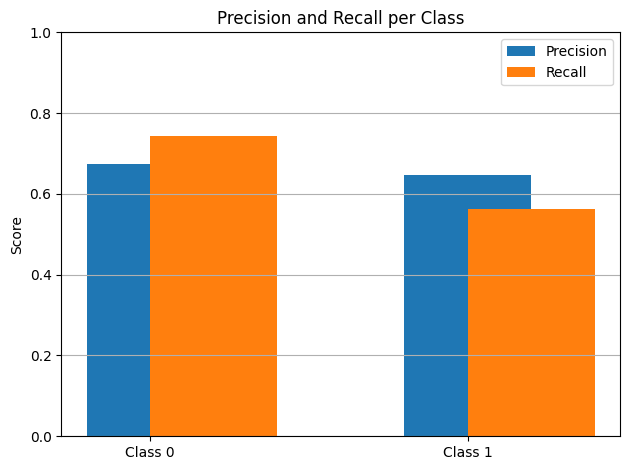

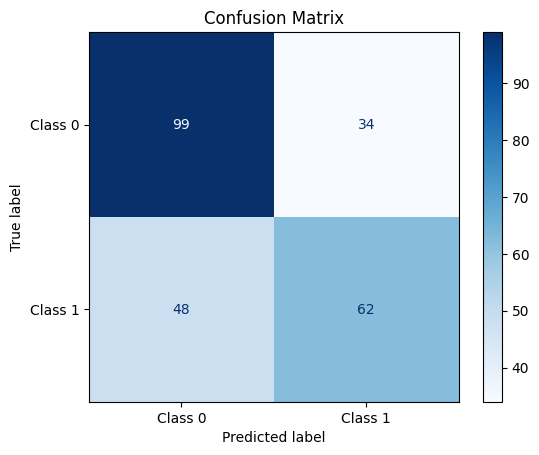

In [455]:
best_class2 = model_selector(svc_class2, lr_class2, knn_class2, rf_class2, xgb_class2, X_test, class2_ytest)

Considering the plot obtained from the ROC - AUC Curve, the model performs above the diagonal of the square indicating that still performs better than a random classifier, which is appropiate, but still not enough to be described as a viable or accurate classifier, in fact, even though its Area under the curve is certainly above 0.6, the model can improve its performance, but considering the limitations of the class quantity, this is reflected on the variation of the line of the plot.

Regarding the table of results of the model provided, this has been the best model that obtained the most accurate and highest F1 Score comparing to the others. This is mainly because the class 2 is the one that has the most quantity of samples, so that the model can interpret in a better way the patterns and the behaviour that a Male patient with ADHD might have. In the recall, we can observe that this model has a general precision of 66% to differentiate a male with ADHD against males that don't and females. We can also observe that the difference between the score of each class is 11% performing better on predicting the class 0 rather than class 1 (the others), showing that the model reasonably behaves in a balanced way and its performance is appropiate for the class 2.

Observing the confusion matrix, the highest values correspond to the diagonal of the square, indicating that the model has remarkable performance in comparison with the rest of the models. In this case, 161 samples were classified correctly against 82 that were misclassified.

### Model #4. Class 3 - ADHD and Female.

Lastly, all those labels whose value is different from 3 will be converted to 1, and those who are 3 will be 0. The model of this class will predict if the patient is Female and has ADHD giving a 0. On the other hand, if the patient is male or is Female and does not have ADHD, then its output will be 1.

In [434]:
class3_ytrain = y_train.applymap(lambda x: 1 if x != 3 else 0) # Conversion of the labels to 0 and 1.
class3_ytest = y_test.applymap(lambda x: 1 if x != 3 else 0)

In [435]:
# SMOTENC is applied to the training set.
class3_Xtrain, class3_ytrain = smote_nc.fit_resample(X_train, class3_ytrain)

#### Support Vector Machine

SVM training for class 3.

In [436]:
param_grid = {
    'C': np.logspace(0.001, 100, 10),  # Regularization strength
    'kernel': ['linear', 'rbf'],   # Commonly used kernels
    'gamma': ['scale', 'auto']     # Kernel coefficient for 'rbf'
}
svc_class3 = model_training(SVC(random_state=42, probability=True), param_grid, class3_Xtrain, class3_ytrain, X_test, class3_ytest)

              precision    recall  f1-score   support

           0       0.35      0.40      0.38        45
           1       0.86      0.83      0.85       198

    accuracy                           0.75       243
   macro avg       0.61      0.62      0.61       243
weighted avg       0.77      0.75      0.76       243

F1 Score: 0.6105769230769231


#### Logistic Regression

LR training for class 3.

In [437]:
param_grid = {
    'C': np.logspace(0.001, 10, 5), # Regularization Strength
    'penalty': ['l2'], # L2 Regularization, commonly used.
    'solver': ['lbfgs', 'liblinear', 'saga'] # Solver eficient for Logistic Regression.
}

lr_class3 = model_training(LogisticRegression(random_state=42), param_grid, class3_Xtrain, class3_ytrain, X_test, class3_ytest)

              precision    recall  f1-score   support

           0       0.50      0.13      0.21        45
           1       0.83      0.97      0.90       198

    accuracy                           0.81       243
   macro avg       0.67      0.55      0.55       243
weighted avg       0.77      0.81      0.77       243

F1 Score: 0.5528156054471844


#### KNN

KNN training for class 3.

In [438]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]                        # Power parameter: 1 = Manhattan, 2 = Euclidean
}

knn_class3 = model_training(KNeighborsClassifier(), param_grid, class3_Xtrain, class3_ytrain, X_test, class3_ytest)

              precision    recall  f1-score   support

           0       0.19      1.00      0.31        45
           1       0.00      0.00      0.00       198

    accuracy                           0.19       243
   macro avg       0.09      0.50      0.16       243
weighted avg       0.03      0.19      0.06       243

F1 Score: 0.15625


#### Random Forest

RF training for class 3.

In [439]:
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees in the forest
    'max_depth': [None, 5, 10],          # Maximum depth of each tree
    'max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy']    # Function to measure the quality of a split
}

rf_class3 = model_training(RandomForestClassifier(class_weight='balanced'), param_grid, class3_Xtrain, class3_ytrain, X_test, class3_ytest)

              precision    recall  f1-score   support

           0       0.19      1.00      0.31        45
           1       1.00      0.01      0.01       198

    accuracy                           0.19       243
   macro avg       0.59      0.50      0.16       243
weighted avg       0.85      0.19      0.07       243

F1 Score: 0.1618195507152487


#### XGBoost

XGBoost training for class 3.

In [440]:
param_grid = {
    'n_estimators': [1500, 2000],
    'max_depth': [3, 6],
    'subsample': [0.5, 1]  # 0.5 is used in order to avoid overfitting.
}

xgb_class3 = model_training(XGBClassifier(random_state=42, device = 'gpu', scale_pos_weight= ((class3_ytrain == 0).sum() / (class3_ytrain == 1).sum()).item()), 
                            param_grid, class3_Xtrain, class3_ytrain, X_test, class3_ytest)

              precision    recall  f1-score   support

           0       0.43      0.13      0.20        45
           1       0.83      0.96      0.89       198

    accuracy                           0.81       243
   macro avg       0.63      0.55      0.55       243
weighted avg       0.76      0.81      0.76       243

F1 Score: 0.5466597864486167


Selection of Best Model

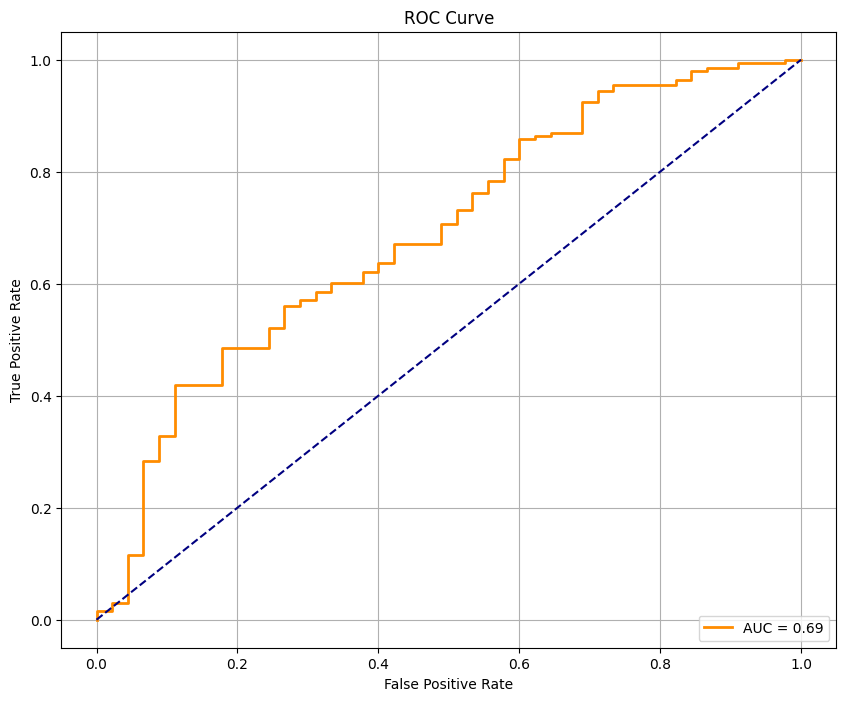

              precision    recall  f1-score   support

           0       0.35      0.40      0.38        45
           1       0.86      0.83      0.85       198

    accuracy                           0.75       243
   macro avg       0.61      0.62      0.61       243
weighted avg       0.77      0.75      0.76       243

The Mathhews Correlation Coefficient is: 0.22257682084276112


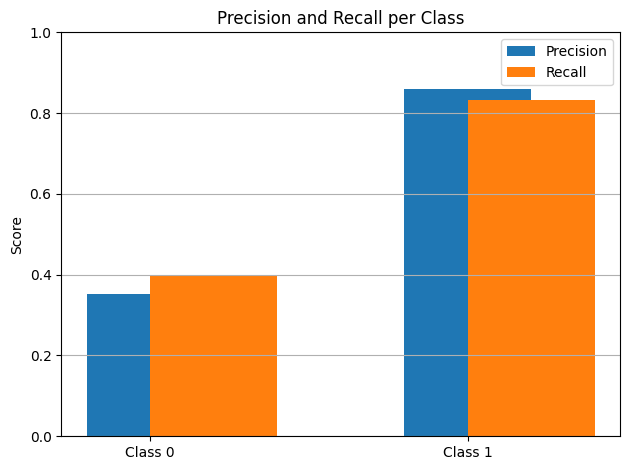

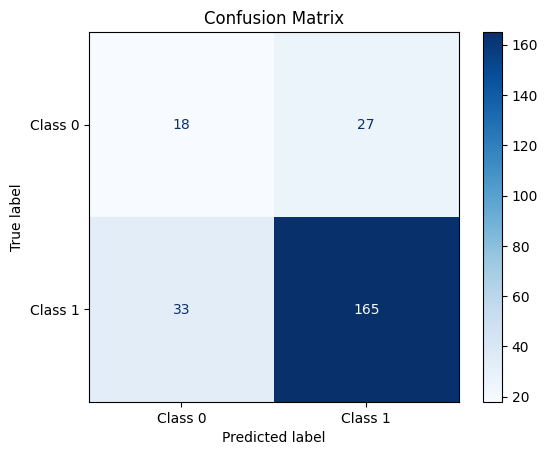

In [456]:
best_class3 = model_selector(svc_class3, lr_class3, knn_class3, rf_class3, xgb_class3, X_test, class3_ytest)

The classification model for the class 3 presents a general performance of 75 % even though there is a high imbalanced behaviour in the classes. For the class 0 a precision of  0.35, a Recall of 0.40 and a F1 Score of 0.38 was obtained, indicating that the model has a very poor performance on identifying the class 0 as well as to predict it. In contrast, considering the class 1, which represents most of the samples in the dataset, the model got a score of 0.85, a recall of 0.83 and a precision of 0.86. This affirms that this model pretty skewed towards the majority class achieving a high effectiveness and reliabilty on identify and classify the class 1 rather than class 0. 

Regarding the MCC (Matthews Correlation Coefficient) which is 0.22, this represents a low correlation between the predictions of the model and the true labels, showing that the classifier does not generalize well and is highly biased against a single class, also, this can be observed in the confusion matrix where the highest number of correct predictions are on the class 1, and in the class 0, the correct ones have the lowest value in the matrix.

### General Model

The next section performs the training of the general model which is a CategoryBoost or commonly called as "CatBoost", a model that can address problems where classes are highly imbalanced or biased. Here, another Cross Validation will be performed and the predictions for each class will be made using the base models for the building of the training and test set.

In [ ]:
param_grid = {
    'iterations': [1000, 2000], # Number of iterations of the model. 
    'depth': [6, 8, 10], # Depth of the trees.
    'learning_rate': [0.05, 0.1, 0.3], # Learning rate for the model.
    'l2_leaf_reg': [1, 3, 5], # L2 regularization parameter.
}

X_train_gen = np.concatenate(( # Concatenation of the probabilities of each class. Training set.
    best_class0.predict_proba(X_train_gen)[:, 1].reshape(-1, 1),
    best_class1.predict_proba(X_train_gen)[:, 1].reshape(-1, 1),
    best_class2.predict_proba(X_train_gen)[:, 1].reshape(-1, 1),
    best_class3.predict_proba(X_train_gen)[:, 1].reshape(-1, 1)
), axis=1)

X_test_gen = np.concatenate(( # Concatenation of the probabilities of each class. Test set.
    best_class0.predict_proba(X_test)[:, 1].reshape(-1, 1),
    best_class1.predict_proba(X_test)[:, 1].reshape(-1, 1),
    best_class2.predict_proba(X_test)[:, 1].reshape(-1, 1),
    best_class3.predict_proba(X_test)[:, 1].reshape(-1, 1)
), axis=1)


model_general = model_training( # Training of the general model.
    CatBoostClassifier(verbose=0, random_state=42), param_grid, X_train_gen, y_train_gen, X_test_gen, y_test)

              precision    recall  f1-score   support

           0       0.44      0.11      0.17        38
           1       0.20      0.37      0.26        27
           2       0.64      0.89      0.74       133
           3       0.00      0.00      0.00        45

    accuracy                           0.54       243
   macro avg       0.32      0.34      0.29       243
weighted avg       0.44      0.54      0.46       243

F1 Score: 0.2938772563685408


The next section performs the plot of the ROC - AUC Curve, Confussion Matrix and the Bar plot of the Precision and Recall.
The code used for ROC AUC Curve was taken from: https://www.geeksforgeeks.org/multiclass-receiver-operating-characteristic-roc-in-scikit-learn/

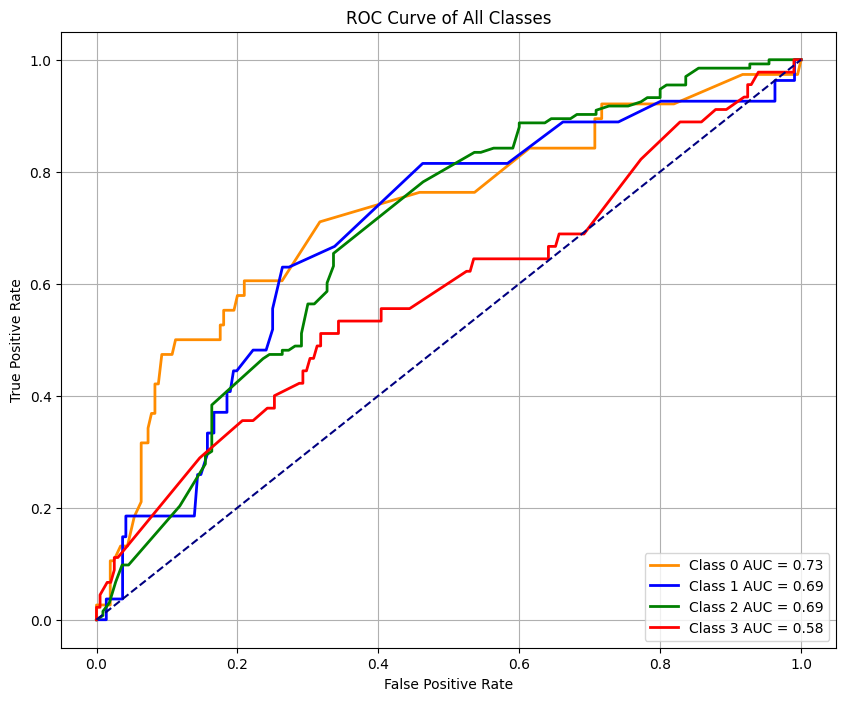

              precision    recall  f1-score   support

     Class 0       0.44      0.11      0.17        38
     Class 1       0.20      0.37      0.26        27
     Class 2       0.64      0.89      0.74       133
     Class 3       0.00      0.00      0.00        45

    accuracy                           0.54       243
   macro avg       0.32      0.34      0.29       243
weighted avg       0.44      0.54      0.46       243



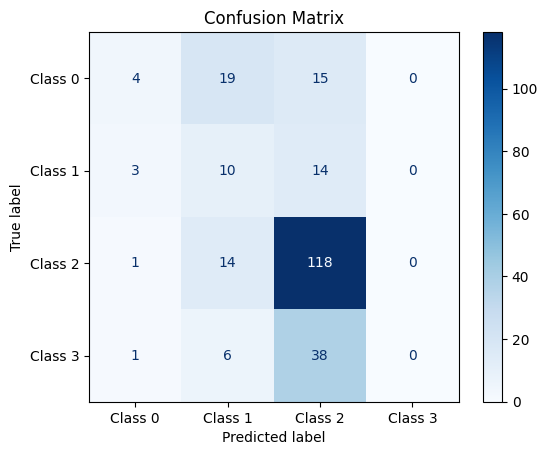

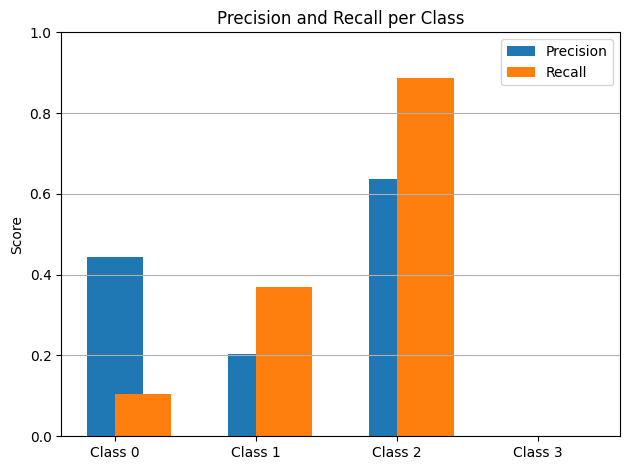

In [468]:
y_prob = model_general.predict_proba(X_test_gen)  # Get the probabilities for each class

# Calculate ROC and AUC for each class
fpr_0, tpr_0, _ = roc_curve(y_test, y_prob[:, 0], pos_label=0)  # Class 0
roc_auc_0 = auc(fpr_0, tpr_0)

fpr_1, tpr_1, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)  # Class 1
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, y_prob[:, 2], pos_label=2)  # Class 2
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test, y_prob[:, 3], pos_label=3)  # Class 3
roc_auc_3 = auc(fpr_3, tpr_3)

# Plot all ROC Curves on the same plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'Class 0 AUC = {roc_auc_0:.2f}')
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'Class 1 AUC = {roc_auc_1:.2f}')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label=f'Class 2 AUC = {roc_auc_2:.2f}')
plt.plot(fpr_3, tpr_3, color='red', lw=2, label=f'Class 3 AUC = {roc_auc_3:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.title('ROC Curve of All Classes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print classification report
y_pred = model_general.predict(X_test_gen)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Calculate precision and recall for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

# Create bar chart for precision and recall
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
x = range(len(classes))

# Plot precision and recall
plt.bar(x, precision, width=0.4, label='Precision', align='center')
plt.bar(x, recall, width=0.4, label='Recall', align='edge')
plt.ylabel('Score')
plt.title('Precision and Recall per Class')
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Analysing the results acqured for the last model which is the general model that will receive the base models predictions, this presents an important bias towards the class 2, which is the majority class. As seen, the general model has an overall performance of 54 % in accuracy, however shows an uneven performance across classes. 
The model's performance in class 0 shows a very low precision (0.44) and its recall is even lower (0.11), reflecting that the model struggles to identitfy that class. In class 1, the precision is 20% and recall is 37%, which also demonstrates a poor and non viable performance for the application. But, despite this, the model can identify and classify samples that might be labeled as class 2, obtaining better results, such as a score of 0.74, a precision of 0.64 and recall of 0.89. This mainly because the presence of majority class and as the confusion matrix alsp states, that is the class that the model can predict with high accuracy in comparison with the others given that this is the class with the most samples

Lastly, The general model is not even capable to classify or identify the class 3 given that the score results are nearly zero and in the confusion matrix all the results were incorrect. Also, as the ROC - AUC shows, since the area under the curve is nearly 0.5, this indicates that the model during classification in class 3 performs similar to a random classifier, in which its training was not useful along with its inner parameters or can not recognize the patterns that this class differentiates from the others. In conclusion, a better approach is to use the base model of the class 3 rather than combining it using the ensemble strategy.

### END OF THE NOTEBOOK